# Binary Classification with Laplace approximation

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/ApproximateGPs.jl/blob/master/examples/c-comparisons/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/ApproximateGPs.jl/dev/examples/c-comparisons/).*

This example demonstrates how to carry out non-conjugate Gaussian process
inference using the Laplace approximation.

For a basic introduction to the functionality of this library, please refer
to the User Guide.

## Setup

In [1]:
using ApproximateGPs
using LinearAlgebra
using Distributions
using LogExpFunctions: logistic, softplus, invsoftplus
using Zygote
using Optim

using Plots
default(; legend=:outertopright, size=(700, 400))

using Random
Random.seed!(1);

## Generate training data

We create a binary-labelled toy dataset:

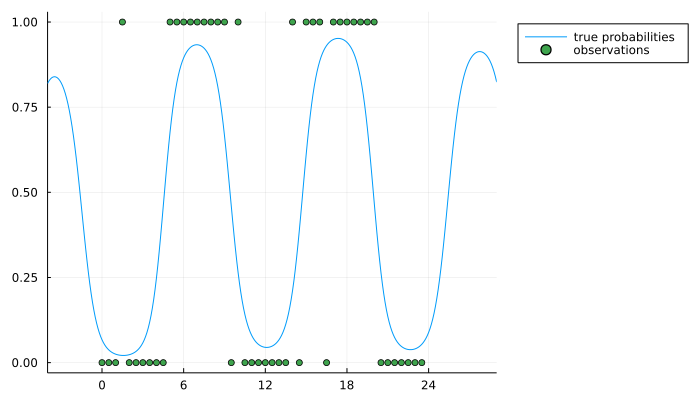

In [2]:
Xgrid = -4:0.1:29  # for visualization
X = range(0, 23.5; length=48)  # training inputs
f(x) = 3 * sin(10 + 0.6x) + sin(0.1x) - 1  # latent function
fs = f.(X)  # latent function values at training inputs

lik = BernoulliLikelihood()  # has logistic invlink by default
# could use other invlink, e.g. normcdf(f) = cdf(Normal(), f)

invlink = lik.invlink  # logistic function
ps = invlink.(fs)  # probabilities at the training inputs
Y = [rand(Bernoulli(p)) for p in ps]  # observations at the training inputs
# could do this in one call as `Y = rand(lik(fs))`

function plot_data()
    plot(; xlims=extrema(Xgrid), xticks=0:6:24)
    plot!(Xgrid, invlink ∘ f; label="true probabilities")
    return scatter!(X, Y; label="observations", color=3)
end

plot_data()

## Create a latent GP

Here we write a function that creates our latent GP prior, given the
hyperparameter vector `theta`. Compared to a "vanilla" GP, the `LatentGP`
requires a function or functor that maps from the latent GP `f` to the
distribution of observations `y`. This functor is commonly called "the
likelihood".

In [3]:
function build_latent_gp(theta)
    # `theta` is unconstrained, but kernel variance and lengthscale must be positive:
    variance = softplus(theta[1])
    lengthscale = softplus(theta[2])

    kernel = variance * with_lengthscale(SqExponentialKernel(), lengthscale)

    dist_y_given_f = BernoulliLikelihood()  # has logistic invlink by default
    # We could also be explicit and define it as a function:
    # dist_y_given_f(f) = Bernoulli(invlink(f))

    jitter = 1e-8  # required for numeric stability
    return LatentGP(GP(kernel), dist_y_given_f, jitter)
end;

We define a latent GP at our initial hyperparameter values, here with
variance 1.0 and lengthscale 5.0:

In [4]:
theta0 = [invsoftplus(1.0), invsoftplus(5.0)]

lf = build_latent_gp(theta0)

lf.f.kernel

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Scale Transform (s = 0.2)
	- σ² = 1.0

We can now compute the Laplace approximation ``q(f)`` to the true posterior
``p(f | y)``:

In [5]:
f_post = posterior(LaplaceApproximation(), lf(X), Y)

AbstractGPs.ApproxPosteriorGP{ApproximateGPs.LaplaceApproximation{NamedTuple{(), Tuple{}}}, AbstractGPs.FiniteGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, LinearAlgebra.Diagonal{Float64, FillArrays.Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}, ApproximateGPs.LaplaceCache{Matrix{Float64}, Vector{Float64}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}(ApproximateGPs.LaplaceApproximation{NamedTuple{(), Tuple{}}}(NamedTuple()), AbstractGPs.FiniteGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}}, StepRa

This finds a mode of the posterior (for the given values of the
hyperparameters) using iterated Newton's method (i.e. solving an optimisation
problem) and then constructs a Gaussian approximation to the posterior by
matching the curvature at the mode.

Let's plot samples from this approximate posterior:

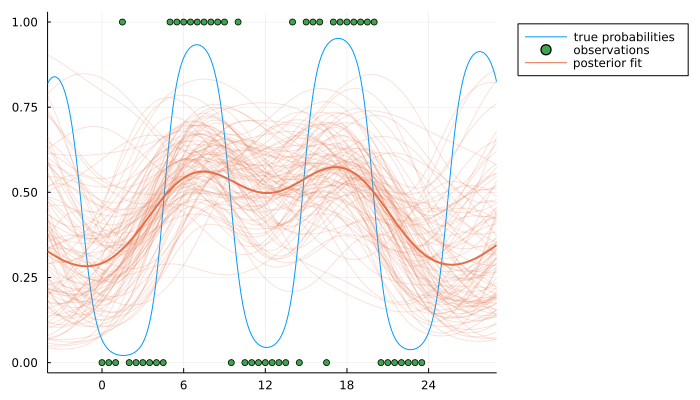

In [6]:
function plot_samples!(Xgrid, fpost; samples=100, color=2)
    fx = fpost(Xgrid, 1e-8)
    fsamples = rand(fx, samples)
    plot!(Xgrid, invlink.(fsamples); color, alpha=0.2, label="")
    return plot!(Xgrid, invlink.(mean(fx)); color, lw=2, label="posterior fit")
end

p1 = plot_data()
plot_samples!(Xgrid, f_post)

We can improve this fit by optimising the hyperparameters. For exact Gaussian
process regression, the maximization objective is the marginal likelihood.
Here, we can only optimise an _approximation_ to the marginal likelihood.

## Optimise the hyperparameters

ApproximateGPs provides a convenience function `build_laplace_objective` that
constructs an objective function for optimising the hyperparameters, based on
the Laplace approximation to the log marginal likelihood.

In [7]:
objective = build_laplace_objective(build_latent_gp, X, Y);

We pass this objective to Optim.jl's LBFGS optimiser:

In [8]:
training_results = Optim.optimize(
    objective, θ -> only(Zygote.gradient(objective, θ)), theta0, LBFGS(); inplace=false
)

 * Status: success

 * Candidate solution
    Final objective value:     2.566186e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.87e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.32e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.95e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e-13 ≰ 0.0e+00
    |g(x)|                 = 1.63e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    11
    f(x) calls:    33
    ∇f(x) calls:   33


Now that we have (hopefully) better hyperparameter values, we need to construct a LatentGP prior with these values:

In [9]:
lf2 = build_latent_gp(training_results.minimizer)

lf2.f.kernel

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Scale Transform (s = 0.5826418867620446)
	- σ² = 7.7095249871489235

Finally, we need to construct again the (approximate) posterior given the
observations for the latent GP with optimised hyperparameters:

In [10]:
f_post2 = posterior(LaplaceApproximation(; f_init=objective.f), lf2(X), Y)

AbstractGPs.ApproxPosteriorGP{ApproximateGPs.LaplaceApproximation{NamedTuple{(:f_init,), Tuple{Vector{Float64}}}}, AbstractGPs.FiniteGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.ScaledKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ScaleTransform{Float64}}, Float64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, LinearAlgebra.Diagonal{Float64, FillArrays.Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}, ApproximateGPs.LaplaceCache{Matrix{Float64}, Vector{Float64}, LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}(ApproximateGPs.LaplaceApproximation{NamedTuple{(:f_init,), Tuple{Vector{Float64}}}}((f_init = [-1.4948149503896146, -1.3799174371435292, -1.3087408466992694, -1.3793046700302523, -1.6120322035012922, -1.9151959322674217, -2.1097823562393874, -2.007015138095156, -1.498896086694608, -0.613233093879237

By passing `f_init=objective.f` we let the Laplace approximation "warm-start"
at the last point of the inner-loop Newton optimisation; `objective.f` is a
field on the `objective` closure.

Let's plot samples from the approximate posterior for the optimised hyperparameters:

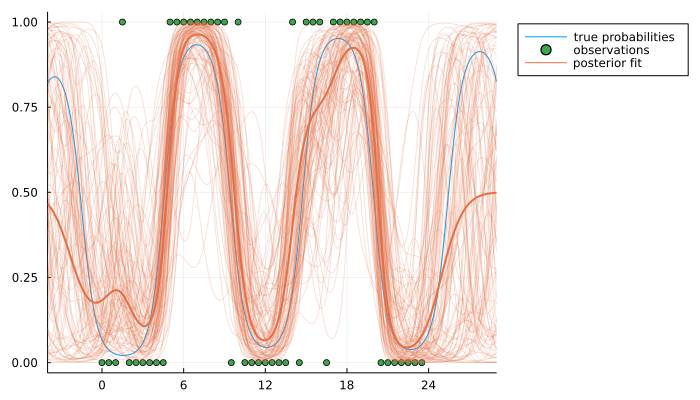

In [11]:
p2 = plot_data()
plot_samples!(Xgrid, f_post2)

### Package and system information
#### Package version
```julia
      Status `~/work/ApproximateGPs.jl/ApproximateGPs.jl/examples/c-comparisons/Project.toml`
  [298c2ebc] ApproximateGPs v0.2.8
  [31c24e10] Distributions v0.25.48
  [98b081ad] Literate v2.12.1
  [2ab3a3ac] LogExpFunctions v0.3.6
  [429524aa] Optim v1.6.1
  [91a5bcdd] Plots v1.25.10
  [e88e6eb3] Zygote v0.6.34
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
```
#### Computer information
```
Julia Version 1.6.5
Commit 9058264a69 (2021-12-19 12:30 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_DEBUG = Documenter
```
#### Manifest
To reproduce this notebook's package environment, you can [download the full Manifest.toml](c-comparisons/Manifest.toml).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*